# Prophet Model for Time Series Forecasting

This notebook demonstrates Facebook Prophet for stock price forecasting with trend and seasonality decomposition.

**Contents:**
1. **Model Overview** - Understanding Prophet components
2. **Model Fitting** - Training the Prophet model
3. **Component Analysis** - Trend and seasonality decomposition
4. **Changepoint Detection** - Identifying trend changes
5. **Evaluation** - Performance metrics (MAE, RMSE, MAPE)
6. **Forecasting** - Future predictions with uncertainty intervals
7. **Hyperparameter Tuning** - Optimizing model parameters

**Prophet Features:**
- Handles missing data and outliers
- Automatic seasonality detection (yearly, weekly, daily)
- Changepoint detection for trend shifts
- Easy incorporation of holidays/events
- Uncertainty intervals for predictions

## Setup

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Suppress Prophet/cmdstanpy logging
import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Add project root to path
sys.path.insert(0, os.path.dirname(os.getcwd()))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Project modules
import config
from src.data_cleaning import cleaned_data_loader
from src.models.baseline import train_test_split
from src.models.prophet_model import (
    ProphetModel,
    prepare_prophet_data,
    evaluate_prophet,
    forecast_future_prophet,
    run_prophet_analysis,
    tune_prophet_hyperparameters
)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print("Configuration:")
print(f"  Train/Test Split: {config.TRAIN_TEST_SPLIT}")
print(f"  Prediction Horizon: {config.PREDICTION_HORIZON_DAYS} days")
print(f"  Seasonality Mode: {config.PROPHET_SEASONALITY_MODE}")
print(f"  Yearly Seasonality: {config.PROPHET_YEARLY_SEASONALITY}")
print(f"  Weekly Seasonality: {config.PROPHET_WEEKLY_SEASONALITY}")
print(f"  Changepoint Prior Scale: {config.PROPHET_CHANGEPOINT_PRIOR_SCALE}")

Importing plotly failed. Interactive plots will not work.


Configuration:
  Train/Test Split: 0.8
  Prediction Horizon: 20 days
  Seasonality Mode: additive
  Yearly Seasonality: True
  Weekly Seasonality: True
  Changepoint Prior Scale: 0.05


## Load Data

In [2]:
# Load cleaned data
data = cleaned_data_loader()

print(f"\nData shape: {data.shape}")
print(f"Date range: {data.index.min()} to {data.index.max()}")
data.tail()

Loading cleaned data from: data/processed\cleaned_data_20260120_010244.csv
Loaded 1519 data points
Date range: 2020-01-02 00:00:00 to 2026-01-16 00:00:00
Columns: Open, High, Low, Close, Volume

Data shape: (1519, 5)
Date range: 2020-01-02 00:00:00 to 2026-01-16 00:00:00


,Open,High,Low,Close,Volume
Date,,,,,
2026-01-12,259.160004,261.299988,256.799988,260.250000,45263800
2026-01-13,258.720001,261.809998,258.390015,261.049988,45730800
2026-01-14,259.489990,261.820007,256.709991,259.959991,40019400
2026-01-15,260.649994,261.040009,257.049988,258.209991,39388600
2026-01-16,257.899994,258.899994,254.929993,255.529999,72018600


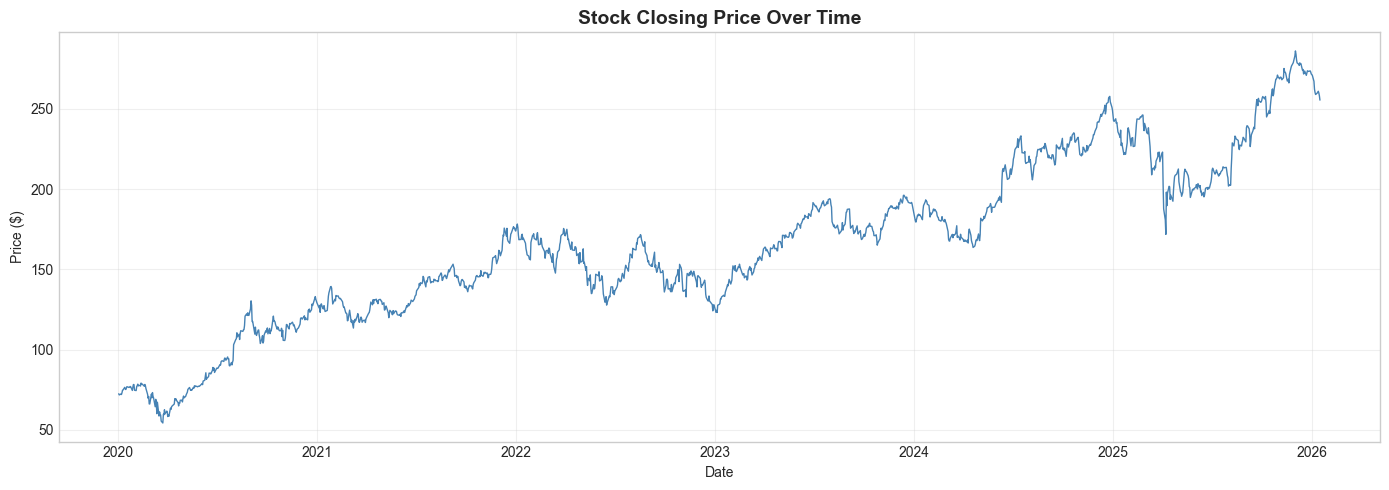

In [3]:
# Plot the time series
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(data.index, data['Close'], color='steelblue', linewidth=1)
ax.set_title('Stock Closing Price Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Train/Test Split

In [4]:
# Split data
train, test = train_test_split(data, train_ratio=config.TRAIN_TEST_SPLIT)

print(f"\nTrain set: {len(train)} samples")
print(f"Test set: {len(test)} samples")

Train/Test Split:
  Train: 1215 samples (2020-01-02 to 2024-10-29)
  Test: 304 samples (2024-10-30 to 2026-01-16)

Train set: 1215 samples
Test set: 304 samples


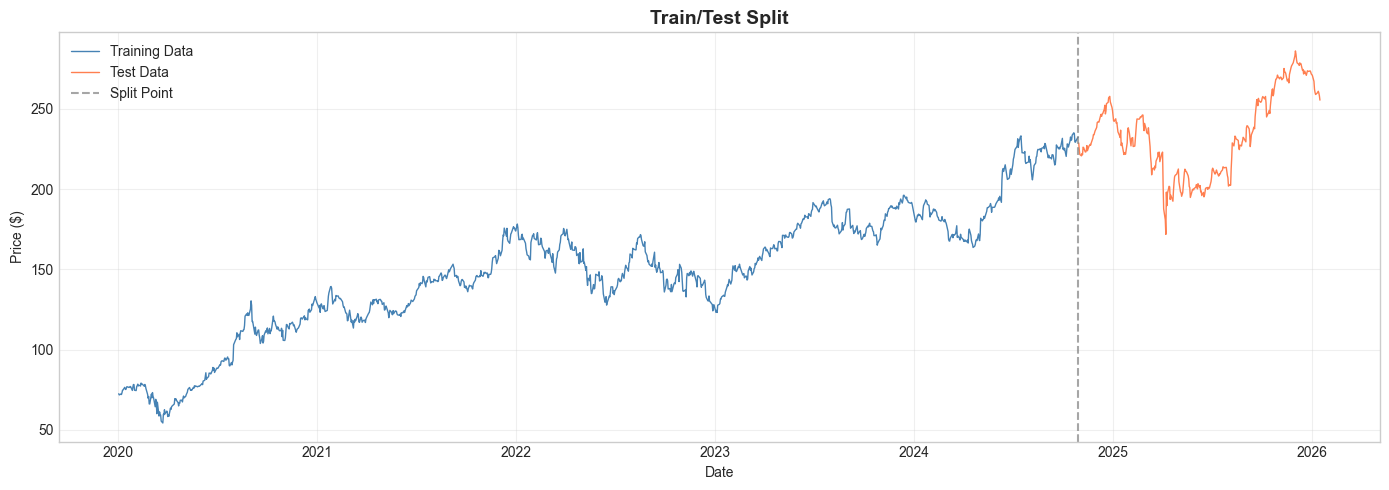

In [5]:
# Visualize train/test split
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train.index, train['Close'], color='steelblue', label='Training Data', linewidth=1)
ax.plot(test.index, test['Close'], color='coral', label='Test Data', linewidth=1)
ax.axvline(x=train.index[-1], color='gray', linestyle='--', alpha=0.7, label='Split Point')
ax.set_title('Train/Test Split', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 1. Prophet Data Format

Prophet requires data in a specific format:
- `ds`: datetime column (date stamp)
- `y`: target variable (value to predict)

In [6]:
# Prepare data for Prophet
prophet_df = prepare_prophet_data(train, column='Close')

print("Prophet Data Format:")
print(prophet_df.head())
print(f"\nShape: {prophet_df.shape}")

Prophet Data Format:
          ds          y
0 2020-01-02  72.468277
1 2020-01-03  71.763741
2 2020-01-06  72.335564
3 2020-01-07  71.995331
4 2020-01-08  73.153496

Shape: (1215, 2)


## 2. Model Fitting

Fit Prophet model with default configuration.

In [7]:
# Create and fit Prophet model
model = ProphetModel(
    seasonality_mode='additive',
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_prior_scale=0.05
)

model.fit(train, column='Close')

print(f"\nModel Parameters:")
params = model.get_params()
for key, value in params.items():
    print(f"  {key}: {value}")


--- Fitting Prophet Model ---
Training samples: 1215
Date range: 2020-01-02 to 2024-10-29
Seasonality mode: additive
Yearly seasonality: True
Weekly seasonality: True


17:05:46 - cmdstanpy - INFO - Chain [1] start processing
17:05:46 - cmdstanpy - INFO - Chain [1] done processing


Model fitted successfully!

Model Parameters:
  growth: linear
  changepoint_prior_scale: 0.05
  seasonality_mode: additive
  yearly_seasonality: True
  weekly_seasonality: True
  daily_seasonality: False
  interval_width: 0.8
  n_changepoints: 25
  changepoint_range: 0.8
  seasonality_prior_scale: 10.0
  holidays_prior_scale: 10.0


## 3. Component Analysis

Prophet decomposes the time series into:
- **Trend**: Overall direction of the series
- **Yearly Seasonality**: Patterns that repeat each year
- **Weekly Seasonality**: Patterns that repeat each week

In [8]:
# Get components
components = model.get_components()

print("Components available:")
print(components.columns.tolist())
print(f"\nComponents shape: {components.shape}")

Components available:
['ds', 'trend', 'yhat', 'yearly', 'weekly']

Components shape: (1215, 5)


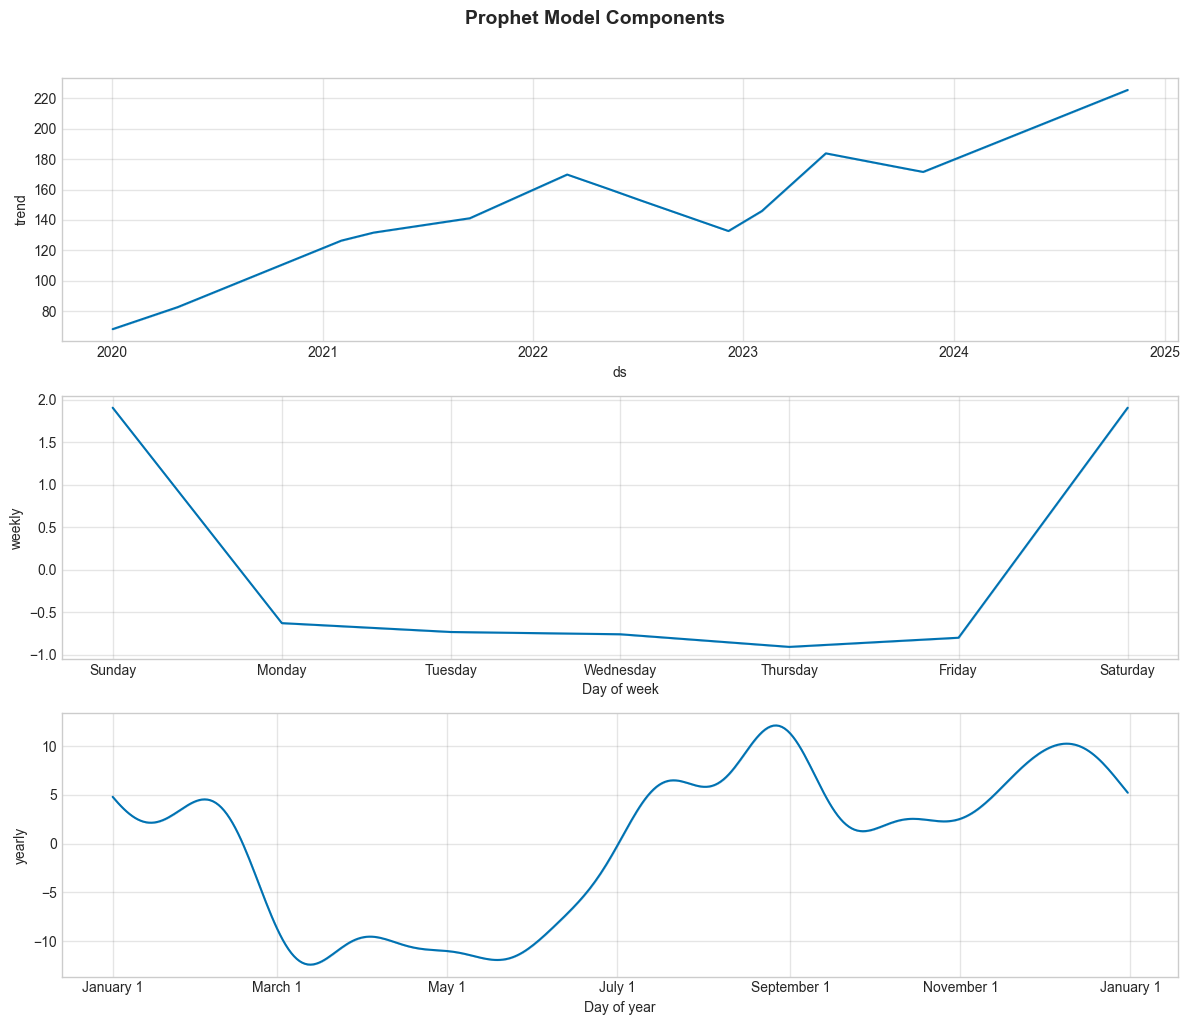

In [9]:
# Plot components using Prophet's built-in function
fig = model.plot_components(figsize=(12, 10))
plt.suptitle('Prophet Model Components', y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

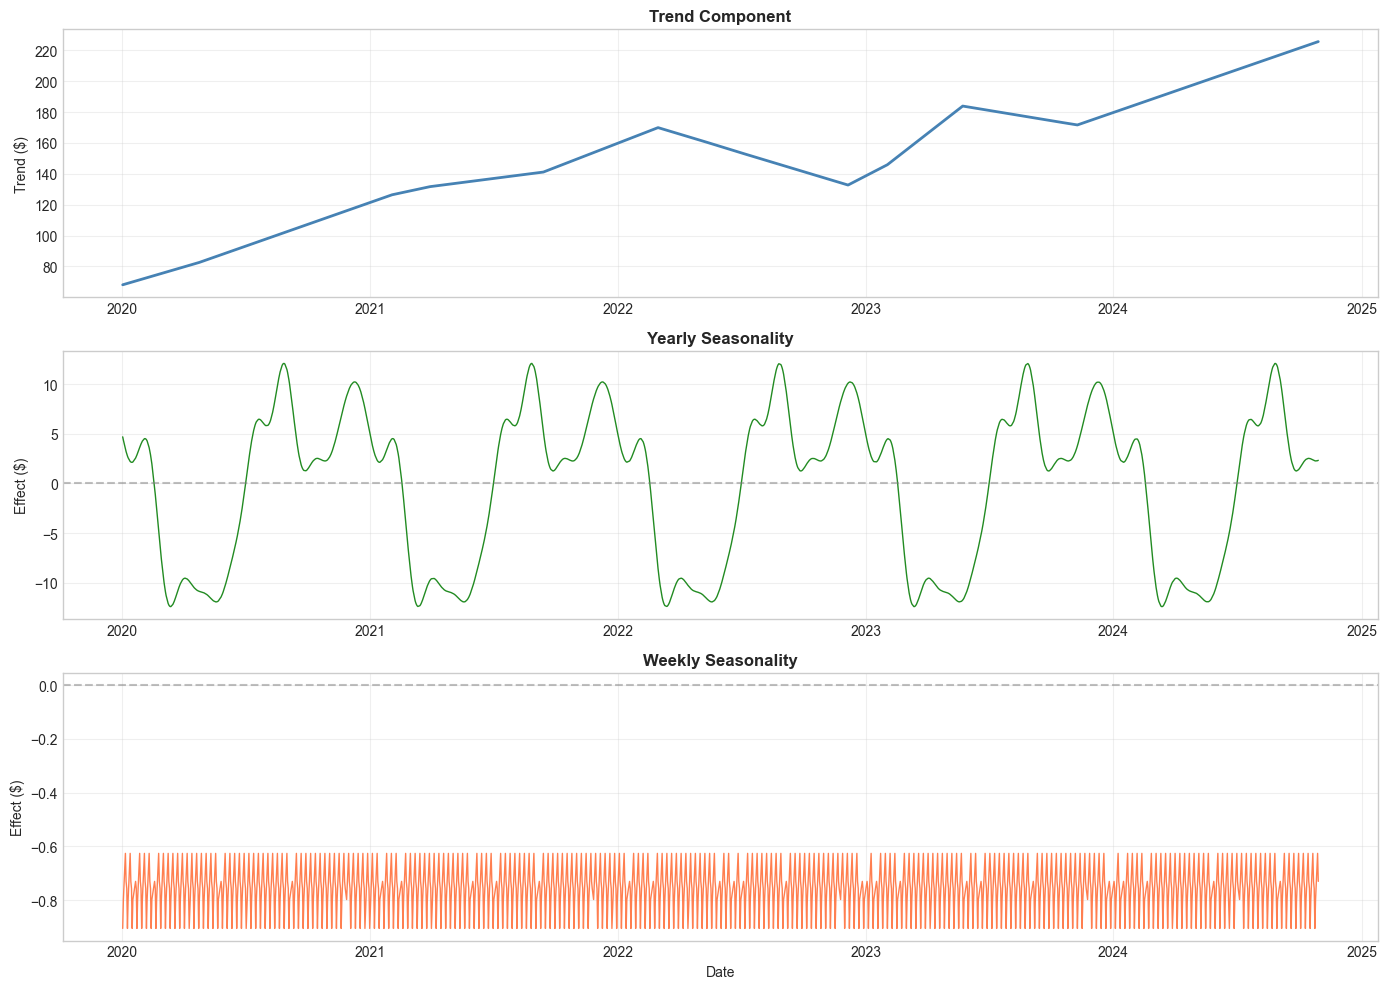

In [10]:
# Custom component visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Trend
axes[0].plot(components['ds'], components['trend'], color='steelblue', linewidth=2)
axes[0].set_title('Trend Component', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Trend ($)')
axes[0].grid(True, alpha=0.3)

# Yearly seasonality (if available)
if 'yearly' in components.columns:
    axes[1].plot(components['ds'], components['yearly'], color='forestgreen', linewidth=1)
    axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[1].set_title('Yearly Seasonality', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Effect ($)')
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'Yearly Seasonality Not Included', 
                 ha='center', va='center', transform=axes[1].transAxes)

# Weekly seasonality (if available)
if 'weekly' in components.columns:
    axes[2].plot(components['ds'], components['weekly'], color='coral', linewidth=1)
    axes[2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[2].set_title('Weekly Seasonality', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Effect ($)')
    axes[2].grid(True, alpha=0.3)
else:
    axes[2].text(0.5, 0.5, 'Weekly Seasonality Not Included', 
                 ha='center', va='center', transform=axes[2].transAxes)

plt.tight_layout()
plt.show()

## 4. Changepoint Detection

Prophet automatically detects points where the trend changes significantly.

In [11]:
# Get changepoints
changepoints = model.get_changepoints()

print(f"Number of changepoints detected: {len(changepoints)}")
print("\nTop changepoints by magnitude:")
if len(changepoints) > 0:
    changepoints_sorted = changepoints.reindex(changepoints['delta'].abs().sort_values(ascending=False).index)
    print(changepoints_sorted.head(10).to_string())

Number of changepoints detected: 25

Top changepoints by magnitude:
            ds     delta
854 2023-05-24 -3.109719
738 2022-12-06  2.693151
544 2022-03-01 -2.257697
971 2023-11-09  1.671034
777 2023-02-02  0.864880
427 2021-09-13  0.852073
272 2021-02-01 -0.445507
311 2021-03-29 -0.287345
78  2020-04-24  0.194447
583 2022-04-26 -0.039181


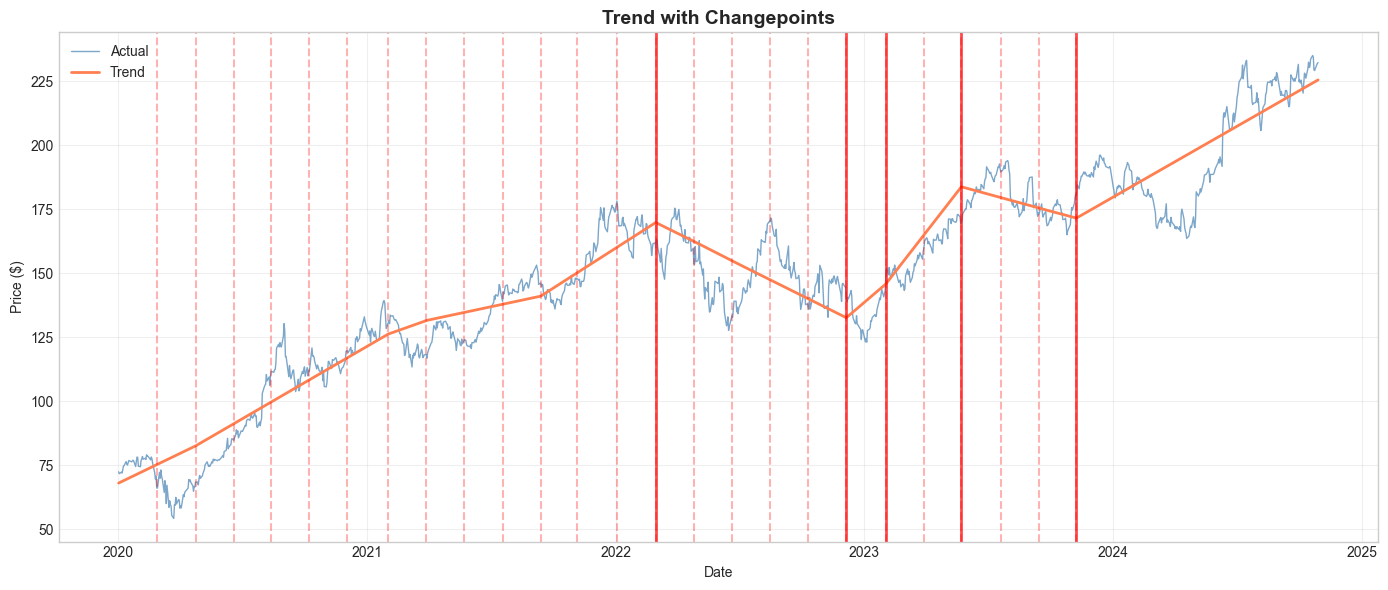


Red dashed lines indicate detected changepoints.
Solid red lines show the top 5 most significant changepoints.


In [12]:
# Visualize changepoints
fig, ax = plt.subplots(figsize=(14, 6))

# Plot actual data
ax.plot(train.index, train['Close'], color='steelblue', label='Actual', linewidth=1, alpha=0.7)

# Plot trend
ax.plot(components['ds'], components['trend'], color='coral', label='Trend', linewidth=2)

# Mark changepoints
if len(changepoints) > 0:
    for idx, row in changepoints.iterrows():
        ax.axvline(x=row['ds'], color='red', linestyle='--', alpha=0.3)
    
    # Mark top 5 changepoints more prominently
    top_changepoints = changepoints.reindex(changepoints['delta'].abs().sort_values(ascending=False).index).head(5)
    for idx, row in top_changepoints.iterrows():
        ax.axvline(x=row['ds'], color='red', linestyle='-', alpha=0.7, linewidth=2)

ax.set_title('Trend with Changepoints', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nRed dashed lines indicate detected changepoints.")
print(f"Solid red lines show the top 5 most significant changepoints.")

## 5. Model Evaluation

In [13]:
# Evaluate model on test set
print("=" * 60)
print("PROPHET MODEL EVALUATION")
print("=" * 60)

evaluation = evaluate_prophet(model, test, column='Close')

PROPHET MODEL EVALUATION

Prophet Evaluation:
  MAE: $25.87
  RMSE: $31.69
  MAPE: 11.71%


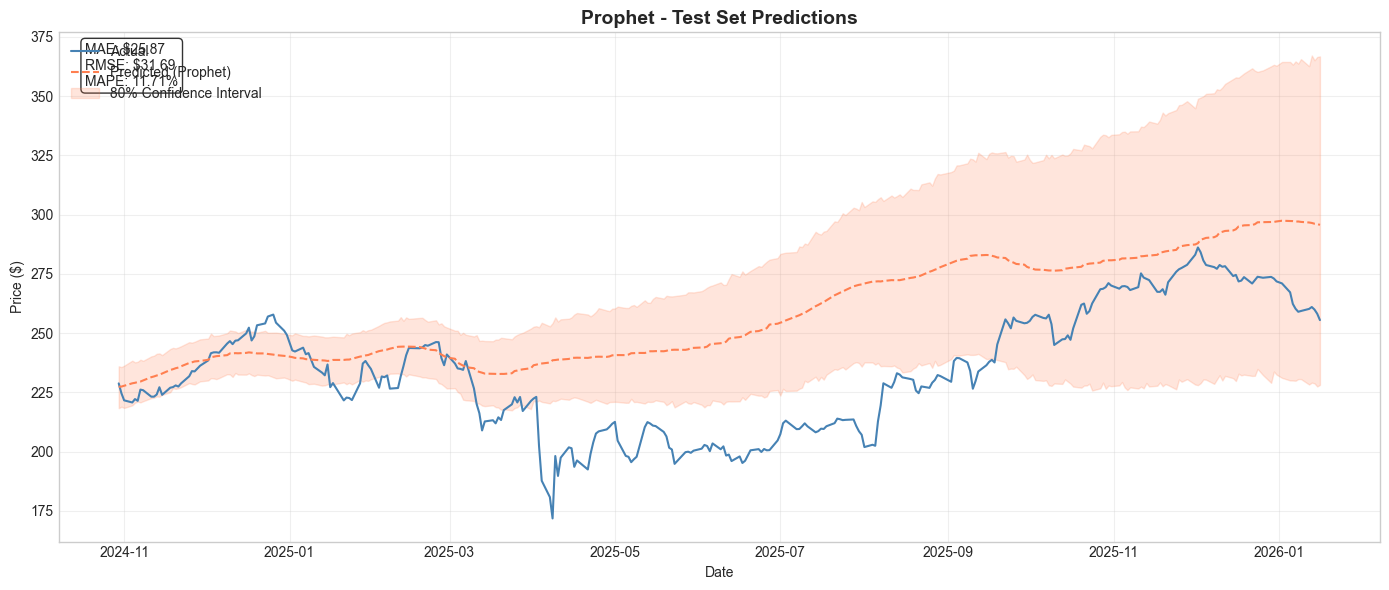

In [14]:
# Plot actual vs predicted on test set
fig, ax = plt.subplots(figsize=(14, 6))

# Actual values
ax.plot(test.index, test['Close'], color='steelblue', label='Actual', linewidth=1.5)

# Predictions
ax.plot(test.index, evaluation['predictions'], color='coral', 
        label=f'Predicted ({model.name})', linewidth=1.5, linestyle='--')

# Confidence intervals
ax.fill_between(test.index, evaluation['lower_bound'], evaluation['upper_bound'],
                color='coral', alpha=0.2, label=f'{config.PROPHET_INTERVAL_WIDTH*100:.0f}% Confidence Interval')

ax.set_title(f'{model.name} - Test Set Predictions', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Add metrics annotation
metrics_text = f'MAE: ${evaluation["mae"]:.2f}\nRMSE: ${evaluation["rmse"]:.2f}\nMAPE: {evaluation["mape"]:.2f}%'
ax.annotate(metrics_text, xy=(0.02, 0.98), xycoords='axes fraction',
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

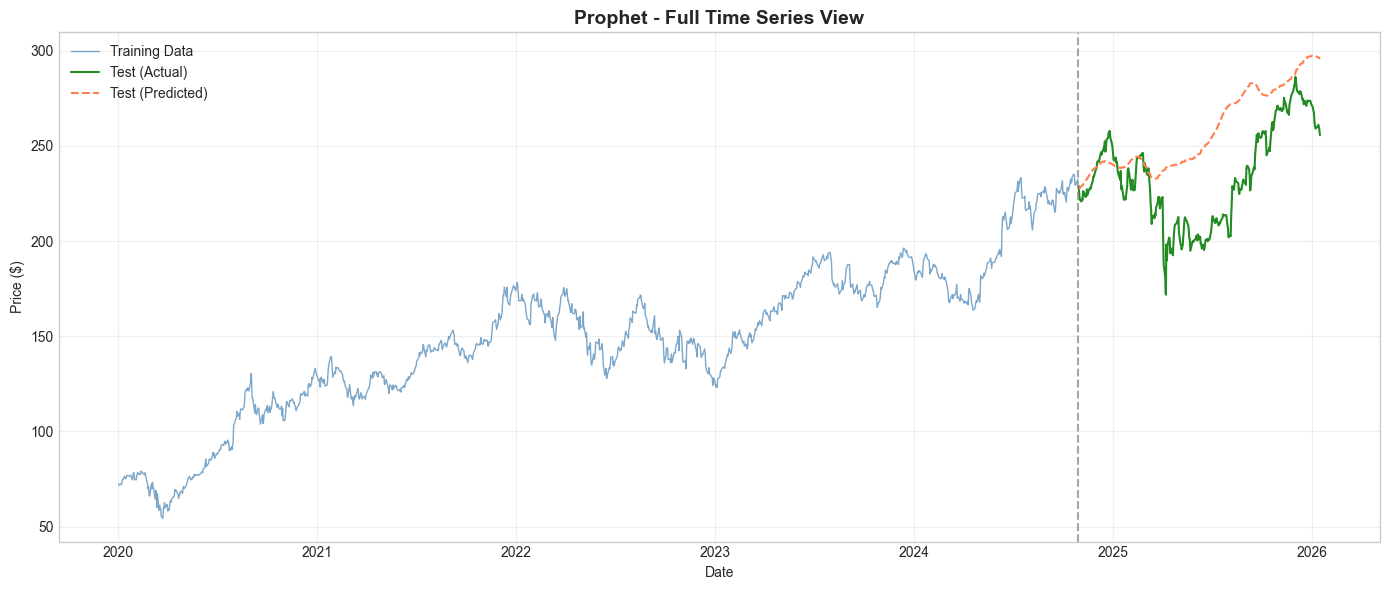

In [15]:
# Full view: Training + Test + Predictions
fig, ax = plt.subplots(figsize=(14, 6))

# Training data
ax.plot(train.index, train['Close'], color='steelblue', label='Training Data', linewidth=1, alpha=0.7)

# Test actual
ax.plot(test.index, test['Close'], color='forestgreen', label='Test (Actual)', linewidth=1.5)

# Test predictions
ax.plot(test.index, evaluation['predictions'], color='coral', 
        label=f'Test (Predicted)', linewidth=1.5, linestyle='--')

# Split line
ax.axvline(x=train.index[-1], color='gray', linestyle='--', alpha=0.7)

ax.set_title(f'{model.name} - Full Time Series View', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Error Analysis

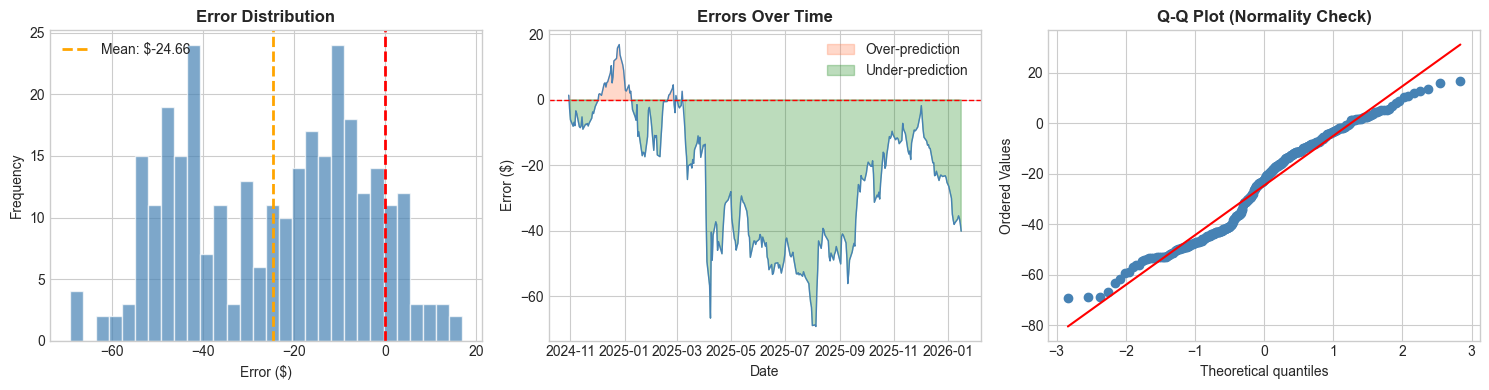

Error Statistics:
  Mean: $-24.66
  Std: $19.90
  Min: $-69.31
  Max: $16.89


In [16]:
# Error distribution
errors = evaluation['errors']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram of errors
axes[0].hist(errors, bins=30, color='steelblue', edgecolor='white', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].axvline(x=np.mean(errors), color='orange', linestyle='--', linewidth=2, label=f'Mean: ${np.mean(errors):.2f}')
axes[0].set_title('Error Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Error ($)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Errors over time
axes[1].plot(test.index, errors, color='steelblue', linewidth=1)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1].fill_between(test.index, 0, errors, where=(errors > 0), color='coral', alpha=0.3, label='Over-prediction')
axes[1].fill_between(test.index, 0, errors, where=(errors < 0), color='forestgreen', alpha=0.3, label='Under-prediction')
axes[1].set_title('Errors Over Time', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Error ($)')
axes[1].legend()

# QQ plot
from scipy import stats
stats.probplot(errors, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
axes[2].get_lines()[0].set_markerfacecolor('steelblue')
axes[2].get_lines()[0].set_markeredgecolor('steelblue')

plt.tight_layout()
plt.show()

print(f"Error Statistics:")
print(f"  Mean: ${np.mean(errors):.2f}")
print(f"  Std: ${np.std(errors):.2f}")
print(f"  Min: ${np.min(errors):.2f}")
print(f"  Max: ${np.max(errors):.2f}")

## 7. Comparing Different Seasonality Modes

In [17]:
# Compare additive vs multiplicative seasonality
print("=" * 60)
print("COMPARING SEASONALITY MODES")
print("=" * 60)

results = {}

for mode in ['additive', 'multiplicative']:
    print(f"\n--- {mode.upper()} ---")
    model_temp = ProphetModel(seasonality_mode=mode)
    model_temp.fit(train, column='Close')
    eval_temp = evaluate_prophet(model_temp, test, column='Close')
    results[mode] = {
        'mae': eval_temp['mae'],
        'rmse': eval_temp['rmse'],
        'mape': eval_temp['mape']
    }

# Display comparison
comparison_df = pd.DataFrame(results).T
comparison_df.columns = ['MAE ($)', 'RMSE ($)', 'MAPE (%)']
print("\n" + "=" * 60)
print("COMPARISON RESULTS")
print("=" * 60)
print(comparison_df.to_string())

best_mode = comparison_df['MAE ($)'].idxmin()
print(f"\nBest Seasonality Mode (by MAE): {best_mode}")

COMPARING SEASONALITY MODES

--- ADDITIVE ---

--- Fitting Prophet Model ---
Training samples: 1215
Date range: 2020-01-02 to 2024-10-29
Seasonality mode: additive
Yearly seasonality: True
Weekly seasonality: True


17:05:51 - cmdstanpy - INFO - Chain [1] start processing
17:05:51 - cmdstanpy - INFO - Chain [1] done processing


Model fitted successfully!

Prophet Evaluation:
  MAE: $25.87
  RMSE: $31.69
  MAPE: 11.71%

--- MULTIPLICATIVE ---

--- Fitting Prophet Model ---
Training samples: 1215
Date range: 2020-01-02 to 2024-10-29
Seasonality mode: multiplicative
Yearly seasonality: True
Weekly seasonality: True


17:05:52 - cmdstanpy - INFO - Chain [1] start processing
17:05:55 - cmdstanpy - INFO - Chain [1] done processing


Model fitted successfully!

Prophet Evaluation:
  MAE: $28.29
  RMSE: $34.42
  MAPE: 12.50%

COMPARISON RESULTS
                  MAE ($)   RMSE ($)   MAPE (%)
additive        25.871424  31.688380  11.712586
multiplicative  28.289806  34.422355  12.500468

Best Seasonality Mode (by MAE): additive


## 8. Hyperparameter Tuning (Optional)

Tune key Prophet hyperparameters for better performance.

In [18]:
# Optional: Run hyperparameter tuning (can be slow)
RUN_TUNING = False  # Set to True to run tuning

if RUN_TUNING:
    print("Running hyperparameter tuning (this may take a few minutes)...")
    
    param_grid = {
        'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
        'seasonality_prior_scale': [1.0, 10.0],
        'seasonality_mode': ['additive', 'multiplicative']
    }
    
    tuning_results = tune_prophet_hyperparameters(
        data,
        column='Close',
        param_grid=param_grid,
        train_ratio=config.TRAIN_TEST_SPLIT
    )
    
    print("\nTuning Results:")
    print(tuning_results['all_results'].sort_values('mae').head(10))
else:
    print("Hyperparameter tuning skipped. Set RUN_TUNING = True to run.")

Hyperparameter tuning skipped. Set RUN_TUNING = True to run.


## 9. Future Forecasting

In [19]:
# Refit model on all available data for future forecasting
model_final = ProphetModel(
    seasonality_mode=best_mode,
    changepoint_prior_scale=0.05
)
model_final.fit(data, column='Close')

print(f"Final Model: {model_final.name}")
print(f"Trained on: {len(data)} data points")
print(f"Date range: {data.index.min().strftime('%Y-%m-%d')} to {data.index.max().strftime('%Y-%m-%d')}")


--- Fitting Prophet Model ---
Training samples: 1519
Date range: 2020-01-02 to 2026-01-16
Seasonality mode: additive
Yearly seasonality: True
Weekly seasonality: True


17:05:55 - cmdstanpy - INFO - Chain [1] start processing
17:05:56 - cmdstanpy - INFO - Chain [1] done processing


Model fitted successfully!
Final Model: Prophet
Trained on: 1519 data points
Date range: 2020-01-02 to 2026-01-16


In [20]:
# Generate future forecast
forecast_horizon = config.PREDICTION_HORIZON_DAYS
forecast = forecast_future_prophet(
    model_final,
    horizon=forecast_horizon,
    last_date=data.index[-1]
)

print(f"\nForecast for next {forecast_horizon} trading days:")
print(forecast)


Prophet - 20-day Forecast:
Confidence Level: 80%
              forecast       lower       upper
2026-01-19  252.541879  240.564485  265.302015
2026-01-20  252.404111  239.392203  265.311818
2026-01-21  252.332960  239.585029  265.226595
2026-01-22  252.184740  239.892074  265.000786
2026-01-23  252.531174  240.934354  266.670699
2026-01-26  253.141392  241.260016  266.881901
2026-01-27  253.240156  240.623921  266.691183
2026-01-28  253.390953  240.561135  266.641921
2026-01-29  253.445897  240.436350  266.838143
2026-01-30  253.972537  240.305123  266.306142
... (10 more rows)

Forecast for next 20 trading days:
              forecast       lower       upper
2026-01-19  252.541879  240.564485  265.302015
2026-01-20  252.404111  239.392203  265.311818
2026-01-21  252.332960  239.585029  265.226595
2026-01-22  252.184740  239.892074  265.000786
2026-01-23  252.531174  240.934354  266.670699
2026-01-26  253.141392  241.260016  266.881901
2026-01-27  253.240156  240.623921  266.691183
20

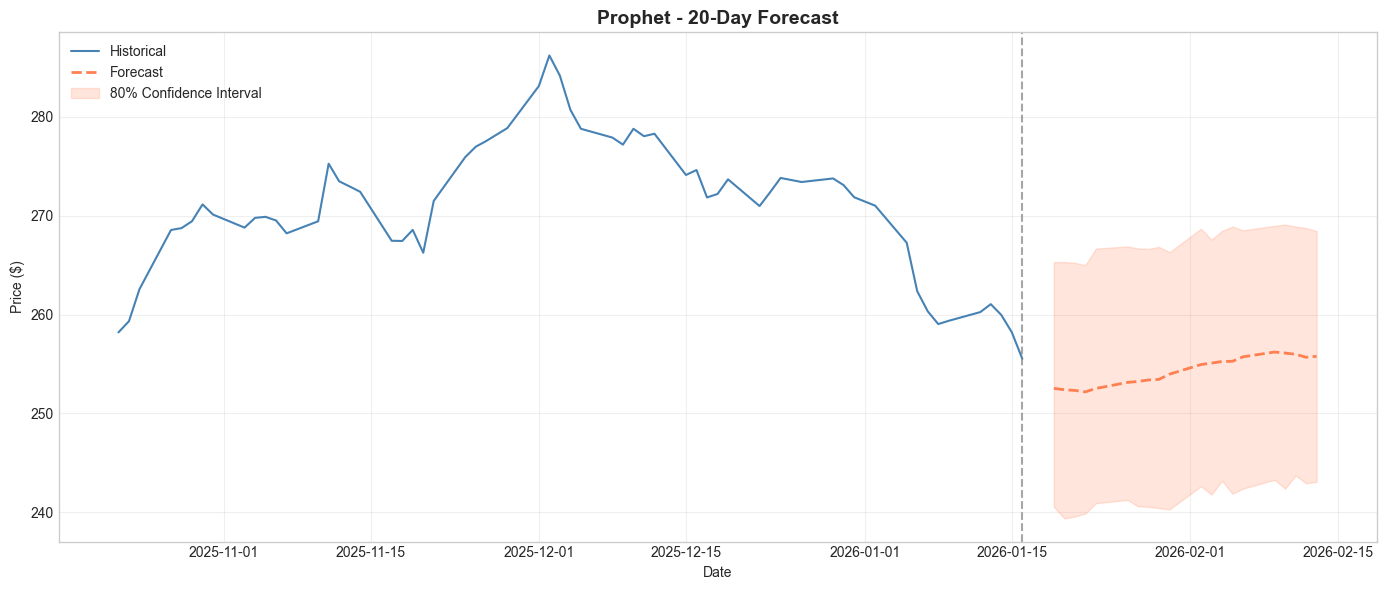


Forecast Summary:
  Last Actual Price: $255.53
  Forecast Start: $252.54
  Forecast End: $255.78
  Forecast Range: $252.18 - $256.21
  Expected Change: 0.10%


In [21]:
# Plot forecast
fig, ax = plt.subplots(figsize=(14, 6))

# Recent historical data (last 60 days)
recent_days = 60
recent_data = data.iloc[-recent_days:]

ax.plot(recent_data.index, recent_data['Close'], color='steelblue', 
        label='Historical', linewidth=1.5)

# Forecast
ax.plot(forecast.index, forecast['forecast'], color='coral', 
        label='Forecast', linewidth=2, linestyle='--')

# Confidence interval
ax.fill_between(forecast.index, forecast['lower'], forecast['upper'],
                color='coral', alpha=0.2, label=f'{model_final.interval_width*100:.0f}% Confidence Interval')

# Vertical line at forecast start
ax.axvline(x=data.index[-1], color='gray', linestyle='--', alpha=0.7)

ax.set_title(f'{model_final.name} - {forecast_horizon}-Day Forecast', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nForecast Summary:")
print(f"  Last Actual Price: ${data['Close'].iloc[-1]:.2f}")
print(f"  Forecast Start: ${forecast['forecast'].iloc[0]:.2f}")
print(f"  Forecast End: ${forecast['forecast'].iloc[-1]:.2f}")
print(f"  Forecast Range: ${forecast['forecast'].min():.2f} - ${forecast['forecast'].max():.2f}")
print(f"  Expected Change: {((forecast['forecast'].iloc[-1] / data['Close'].iloc[-1]) - 1) * 100:.2f}%")

## 10. Summary

In [22]:
print("=" * 60)
print("PROPHET MODEL ANALYSIS SUMMARY")
print("=" * 60)

print(f"\n1. DATA:")
print(f"   Total samples: {len(data)}")
print(f"   Date range: {data.index.min().strftime('%Y-%m-%d')} to {data.index.max().strftime('%Y-%m-%d')}")
print(f"   Train/Test split: {config.TRAIN_TEST_SPLIT * 100:.0f}% / {(1-config.TRAIN_TEST_SPLIT) * 100:.0f}%")

print(f"\n2. MODEL CONFIGURATION:")
print(f"   Seasonality Mode: {model.seasonality_mode}")
print(f"   Yearly Seasonality: {model.yearly_seasonality}")
print(f"   Weekly Seasonality: {model.weekly_seasonality}")
print(f"   Changepoint Prior Scale: {model.changepoint_prior_scale}")

print(f"\n3. CHANGEPOINTS:")
print(f"   Detected: {len(changepoints)}")

print(f"\n4. TEST SET PERFORMANCE:")
print(f"   MAE: ${evaluation['mae']:.2f}")
print(f"   RMSE: ${evaluation['rmse']:.2f}")
print(f"   MAPE: {evaluation['mape']:.2f}%")

print(f"\n5. FORECAST ({forecast_horizon} days):")
print(f"   Current Price: ${data['Close'].iloc[-1]:.2f}")
print(f"   Forecast End: ${forecast['forecast'].iloc[-1]:.2f}")
print(f"   Expected Change: {((forecast['forecast'].iloc[-1] / data['Close'].iloc[-1]) - 1) * 100:.2f}%")

print("\n" + "=" * 60)

PROPHET MODEL ANALYSIS SUMMARY

1. DATA:
   Total samples: 1519
   Date range: 2020-01-02 to 2026-01-16
   Train/Test split: 80% / 20%

2. MODEL CONFIGURATION:
   Seasonality Mode: additive
   Yearly Seasonality: True
   Weekly Seasonality: True
   Changepoint Prior Scale: 0.05

3. CHANGEPOINTS:
   Detected: 25

4. TEST SET PERFORMANCE:
   MAE: $25.87
   RMSE: $31.69
   MAPE: 11.71%

5. FORECAST (20 days):
   Current Price: $255.53
   Forecast End: $255.78
   Expected Change: 0.10%



## Save Results

In [23]:
# Save forecast to CSV
import os

output_dir = os.path.join(os.path.dirname(os.getcwd()), 'data', 'processed')
os.makedirs(output_dir, exist_ok=True)

forecast_file = os.path.join(output_dir, 'prophet_forecast.csv')
forecast.to_csv(forecast_file)
print(f"Forecast saved to: {forecast_file}")

# Save test predictions
test_predictions = pd.DataFrame({
    'actual': test['Close'].values,
    'predicted': evaluation['predictions'],
    'lower': evaluation['lower_bound'],
    'upper': evaluation['upper_bound'],
    'error': evaluation['errors']
}, index=test.index)

predictions_file = os.path.join(output_dir, 'prophet_test_predictions.csv')
test_predictions.to_csv(predictions_file)
print(f"Test predictions saved to: {predictions_file}")

# Save components
components_file = os.path.join(output_dir, 'prophet_components.csv')
components.to_csv(components_file, index=False)
print(f"Components saved to: {components_file}")

Forecast saved to: c:\Users\adilmusali\OneDrive - Tartu Ülikool\Desktop\time_forecast\data\processed\prophet_forecast.csv
Test predictions saved to: c:\Users\adilmusali\OneDrive - Tartu Ülikool\Desktop\time_forecast\data\processed\prophet_test_predictions.csv
Components saved to: c:\Users\adilmusali\OneDrive - Tartu Ülikool\Desktop\time_forecast\data\processed\prophet_components.csv
